# MLND Capstone: Comparison of sentiment analysis using traditional machine learning methods and recurrent neural networks

## Warning: executing "Run All" will take a very long time because it will train 54 RNN models.

## 1. Import packages

In [20]:
import itertools
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from copy import deepcopy
from keras.datasets import imdb
from keras.utils import get_file
import time

sns.set_style('dark')

In [ ]:
# Uncomment and run this command if you do not have the 'punkt' nltk package installed

# nltk.download('punkt')

## 2. Import dataset

https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification

In [21]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

In [22]:
print('Length training set:', len(X_train))
print('Length test set:', len(X_test))

Length training set: 25000
Length test set: 25000


In [23]:
# Dict mappings from word --> id and from id --> word

# All indices need to be shifted by 3. In the dictionary returned by imdb.get_word_index(), indexing starts at 1.
# However, in the actual train/test data, the most frequent word ('the') is indexed as 4.

index_from = 3  

word2id = imdb.get_word_index()
word2id = {key: value + index_from for key, value in word2id.items()}
word2id["<PAD>"] = 0
word2id["<START>"] = 1
word2id["<UNK>"] = 2

id2word = {val: key for key, val in word2id.items()}

In [24]:
print('Number of words in vocab:', len(word2id) - 3)  # -2 is to not take into account indices 0, 1 and 2

Number of words in vocab: 88584


In [25]:
# Check distribution of word counts

all_counts = np.concatenate(X_train + X_test)
print('Retaining top {}% of words'.format(len(np.where(all_counts < 12004)[0]) / len(all_counts)))

Retaining top 0.9543196910260109% of words


In [26]:
# Check frequency of 12001st word

count = 0
for rev in X_train:
    if 12004 in rev:
        count +=1
for rev in X_test:
    if 12004 in rev:
        count +=1
        
print('The 12001th most frequent word appears in {}% ({}) of the documents.'.format((count / 50000) * 100, count))

The 12001th most frequent word appears in 0.098% (49) of the documents.


In [27]:
# Re-import data using only the top 12,000 words

(X_train, y_train), (X_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=12004,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

print('Length training set:', len(X_train))
print('Length test set:', len(X_test))

Length training set: 25000
Length test set: 25000


In [28]:
# Check that there are 12000 unique words (minus indices 1 and 2)

unique_words = set(np.concatenate(X_train + X_test))
print('Number of unique words in training and test sets:', len(sorted(list(unique_words))) - 2)

Number of unique words in training and test sets: 12000


In [29]:
# Remake the mappings taking into account the abridged vocabulary
# This is necessary to avoid a needlessly large pre-trained embedding layer later

index_from = 3  

word2id = imdb.get_word_index()
word2id = {key: value + index_from for key, value in word2id.items() if value <= 12000}
word2id["<PAD>"] = 0
word2id["<START>"] = 1
word2id["<UNK>"] = 2

id2word = {val: key for key, val in word2id.items()}

print('Number of words in vocab:', len(word2id) - 3)

Number of words in vocab: 12000


## 3. Visualize Data

In [30]:
# Distribution of review lengths in the training and test sets combined.

lengths = np.array([len(rev) for rev in np.concatenate([X_train, X_test])])

In [31]:
# Review length stats

print('Mean:', lengths.mean())
print('Std Dev:', lengths.std())
print('Min:', lengths.min())
print('Max:', lengths.max())

Mean: 234.75892
Std Dev: 172.91149458735703
Min: 7
Max: 2494


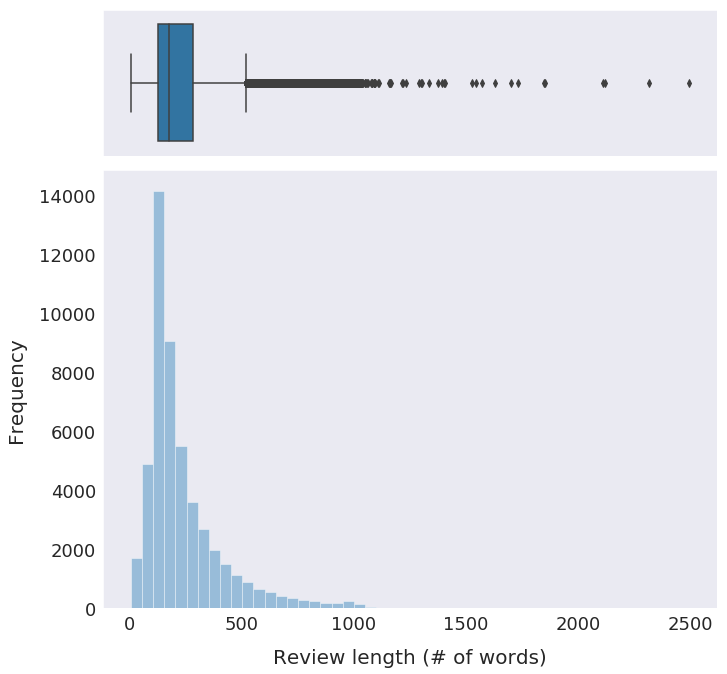

In [32]:
# Plot of review length distribution

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)}, 
                                    figsize=(11,11), edgecolor ='k')

sns.boxplot(lengths, ax=ax_box)
sns.distplot(lengths, kde=False, norm_hist=False, ax=ax_hist)

ax_hist.set_xlabel('Review length (# of words)', fontsize=20, labelpad=15)
ax_hist.set_ylabel('Frequency', fontsize=20, labelpad=13)
ax_hist.tick_params(axis='both', which='major', labelsize=18)
ax_box.set_yticks([])

plt.subplots_adjust(wspace=0, hspace=.05)
plt.savefig('fig1.eps', dpi=300, format='eps')
plt.show()

In [33]:
# Function for returning an original review from an encoded training/test set instance

def display_review(encoded_review):
    print(' '.join(id2word[idx] for idx in encoded_review))

In [34]:
# Example review

display_review(X_train[0])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be prais

## 4. Baseline model: Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
# Function to convert dataset to words and to counts for use with Scikit-Learn

def indices_to_words_counts(train, test):
    """Converts dataset consisting of list of lists of indices into list of lists of words and 
    list of lists of word counts. The binary arg can be set to True for generating vectors of 
    word presence rather than word occurence count."""
    
    # Filter out indices less than 3 (the index 1 is the start_char, 2 is the oov_char, 3 is never used)
    filtered_train = [list(filter(lambda x: x > 3, rev)) for rev in train]
    filtered_test = [list(filter(lambda x: x > 3, rev)) for rev in test]
    
    # Only retain the first 500 words in a review.
    filtered_train = [rev[:500] for rev in filtered_train]
    filtered_test = [rev[:500] for rev in filtered_test]
              
    # Map indices back to words    
    X_train_words = [' '.join(review) for review in [list(map(id2word.get, rev)) for rev in filtered_train]]
    X_test_words = [' '.join(review) for review in [list(map(id2word.get, rev)) for rev in filtered_test]]
    
    # Generate BoW vectors
    count_vec = CountVectorizer(tokenizer=nltk.word_tokenize, binary=False)
    X_train_counts = count_vec.fit_transform(X_train_words)
    X_test_counts = count_vec.transform(X_test_words)
    
    bin_vec = CountVectorizer(tokenizer=nltk.word_tokenize, binary=True)
    X_train_bin = bin_vec.fit_transform(X_train_words)
    X_test_bin = bin_vec.transform(X_test_words)
    
    return (X_train_words, X_train_counts, X_train_bin), (X_test_words, X_test_counts, X_test_bin)

In [36]:
# Convert dataset to words and count

(X_train_words, X_train_counts, X_train_bin), (X_test_words, X_test_counts, X_test_bin) = indices_to_words_counts(X_train, X_test)

In [37]:
# Function to plot confusion matrix (adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.tick_params(axis='both', which='major', labelsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, format='eps')

In [38]:
# Train Naive Bayes classifier and make predictions

start = time.time()
mnb_clf = MultinomialNB().fit(X_train_counts, y_train)
stop = time.time()
print('Time to train:', stop - start)

start = time.time()
predictions = mnb_clf.predict(X_test_counts)
stop = time.time()
print('Time to predict:', stop - start)

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
c_matrix_nb = confusion_matrix(y_test, predictions, labels=[1, 0])

Time to train: 0.031204938888549805
Time to predict: 0.014931917190551758


In [39]:
print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)

Accuracy: 0.81912
Recall: 0.77264
Precision: 0.8518257188216617


Confusion matrix, without normalization
[[ 9658  2842]
 [ 1680 10820]]


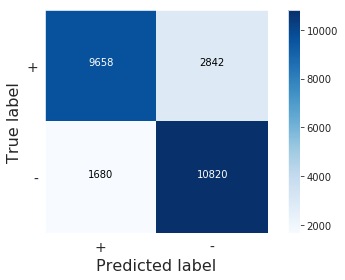

In [40]:
plot_confusion_matrix(c_matrix_nb, ['+', '-'], title='', filename='fig4a.eps')

In [41]:
# Train Bernoulli Naive Bayes classifier and make predictions

start = time.time()
bnb_clf = BernoulliNB().fit(X_train_bin, y_train)
stop = time.time()
print('Time to train:', stop - start)

start = time.time()
predictions = bnb_clf.predict(X_test_bin)
stop = time.time()
print('Time to predict:', stop - start)

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
c_matrix_bnb = confusion_matrix(y_test, predictions, labels=[1, 0])

Time to train: 0.057852983474731445
Time to predict: 0.033313751220703125


In [42]:
print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)

Accuracy: 0.83804
Recall: 0.81344
Precision: 0.8555321834244847


Confusion matrix, without normalization
[[10168  2332]
 [ 1717 10783]]


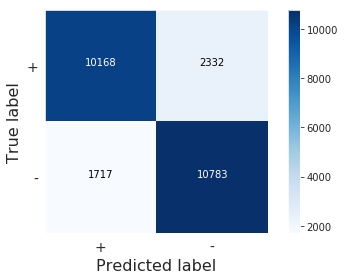

In [43]:
plot_confusion_matrix(c_matrix_bnb, ['+', '-'], title='', filename='fig4b.eps')

## 5. Support Vector Machine

In [44]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [50]:
# Grid search on the C parameter

params = {'C': [0.003, 0.01, 0.03, 0.1, 0.3]}

svm_clf = LinearSVC(loss='hinge', max_iter=5000)
grid = GridSearchCV(svm_clf, params, cv=5, scoring='accuracy').fit(X_train_counts, y_train)
print('Best score:', grid.best_score_)
print('Best estimator:', grid.best_estimator_)

Best score: 0.88352
Best estimator: LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=5000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [46]:
# Train SVM classifier and make predictions

start = time.time()
svm = LinearSVC(loss='hinge', max_iter=3000, C=0.01).fit(X_train_counts, y_train)
stop = time.time()
print('Time to train:', stop - start)

start = time.time()
predictions = grid.predict(X_test_counts)
stop = time.time()
print('Time to predict:', stop - start)

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
c_matrix_svm = confusion_matrix(y_test, predictions, labels=[1, 0])

Time to train: 0.9681868553161621
Time to predict: 0.008473873138427734


In [47]:
print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)

Accuracy: 0.88248
Recall: 0.88472
Precision: 0.8807741318891367


Confusion matrix, without normalization
[[11059  1441]
 [ 1497 11003]]


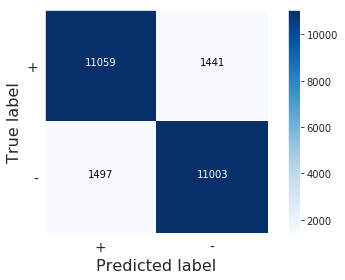

In [48]:
plot_confusion_matrix(c_matrix_svm, ['+', '-'], title='', filename='fig4c.eps')

## 6. LSTM

### Imports and quick look at data

In [202]:
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence 
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, GRU, Embedding, MaxPooling1D, Dropout, Bidirectional, Conv1D
from keras.callbacks import ModelCheckpoint

In [203]:
# Truncate reviews at 500 words and pad shorter reviews with 0s 

max_length = 500 
X_train = sequence.pad_sequences(X_train, maxlen=max_length) 
X_test = sequence.pad_sequences(X_test, maxlen=max_length)

In [204]:
# Split test set into validation set and test set

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [152]:
# Take a look at the padded sequences.

df = pd.DataFrame(X_train)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,...,4472,113,103,32,15,16,5345,19,178,32
1,0,0,0,0,0,0,0,0,0,0,...,52,154,462,33,89,78,285,16,145,95
2,0,0,0,0,0,0,0,0,0,0,...,106,607,624,35,534,6,227,7,129,113
3,687,23,4,2,7339,6,3693,42,38,39,...,26,49,7008,15,566,30,579,21,64,2574
4,0,0,0,0,0,0,0,0,0,0,...,19,14,5,7224,6,226,251,7,61,113


### Word embeddings

In [ ]:
# Make sure you have a subfolder in the main directory called glove.6B containing the contents of
# the glove6B.zip file found here: http://nlp.stanford.edu/data/glove.6B.zip

In [34]:
# Generate dictionary of glove word embedding vectors

def glove_embeddings(filename):
    """Generate dictionary of glove word embedding vectors from glove file."""
    
    embedding = {}
    with open('glove.6B/' + filename, 'r') as f:
        for line in f:
            line = line.strip().split()
            embedding[line[0]] = np.array(line[1:], dtype=np.float64)
            
    return embedding

In [35]:
def pretrained_embedding_layer(embedding, word2id, dim):
    """Creates a Keras Embedding() layer and loads in pre-trained GloVe vectors."""
    
    vocab_len = len(word2id) + 1  # vocab_len should be all words plus 1 for padding
    
    all_embeddings = np.stack(embedding.values())
    mean, std = all_embeddings.mean(), all_embeddings.std()
    
    embedding_matrix = np.zeros((vocab_len, dim))
    
    for word, idx in word2id.items():
        vec = embedding.get(word)
        if vec is not None:
            embedding_matrix[idx, :] = vec
        else:
            embedding_matrix[idx, :] = np.random.normal(mean, std, size=dim)
    
    # Set the first four rows of the embedding matrix to all zeros
    embedding_matrix[0:4] = 0

    # Make Keras embedding layer
    embedding_layer = Embedding(input_dim=vocab_len, output_dim=dim, trainable=True)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer, embedding_matrix

### Functions to automate training/grid search

In [ ]:
# You should have a subfolder in the main directory called saved_models containing the saved model weights.

In [36]:
def build_model(dropout, recurrent_dropout, optimizer, embedding=None, conv1d=False, bidirect=False, summary=True):
    
    if embedding is None:
        dim = 100
    else:
        dim = dim = embedding.get_weights()[0].shape[1]
    
    model = Sequential() 
    if embedding is None:
        model.add(Embedding(input_dim=12004, output_dim=dim, input_length=max_length))
    else:
        model.add(embedding)
    if conv1d:
        model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
    if bidirect:
        model.add(Bidirectional(LSTM(dim, return_sequences=False, 
                                     dropout=dropout, recurrent_dropout=recurrent_dropout)))
    else:
        model.add(LSTM(dim, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    if summary:
        model.summary()
    
    return model

In [37]:
def train_model(params):
    
    dropout = params['dropout']
    recurrent_dropout = params['recurrent_dropout']
    optimizer = params['optimizer']
    embedding = params['embedding']
    conv1d = params['conv1d']
    bidirect = params['bidirect']
    model_no = params['model_no']
    batch_size = params['batch_size']

    model = build_model(dropout, recurrent_dropout, optimizer, embedding, conv1d, bidirect)
    
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.' + model_no + '.hdf5', 
                                   verbose=1, save_best_only=True)
    
    print('Training model', model_no)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, 
              batch_size=batch_size, callbacks=[checkpointer])
    print()

In [158]:
def best_model(parameters):
    
    columns = list(parameters[0].keys())
    columns + ['train_acc', 'test_acc']
    df = pd.DataFrame(columns=columns)

    best_params = None
    best_accuracy = 0
    
    for params in parameters:
        dropout = params['dropout']
        recurrent_dropout = params['recurrent_dropout']
        optimizer = params['optimizer']
        embedding = params['embedding']
        conv1d = params['conv1d']
        bidirect = params['bidirect']
        model_no = params['model_no']
        batch_size = params['batch_size']
        
        model = build_model(dropout, recurrent_dropout, optimizer, embedding, conv1d, bidirect, summary=False)
        model.load_weights('saved_models/weights.' + model_no + '.hdf5')
        print('Evaluating training set accuracy on model', model_no)
        _, train_accuracy = model.evaluate(X_train, y_train)
        print('Evaluating test set accuracy on model', model_no)
        _, test_accuracy = model.evaluate(X_test, y_test)
        
        params['train_acc'] = train_accuracy
        params['test_acc'] = test_accuracy
        df = df.append(params, ignore_index=True)
        
        if accuracy > best_accuracy:
            best_params = params
            best_accuracy = accuracy
        
    return best_params, best_accuracy, df

### a) Plain LSTM

In [160]:
# Models to be evaluated

model_1 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'adam',
           'embedding': None,
           'conv1d': False,
           'bidirect': False,
           'model_no': '1',
           'batch_size': 32}

model_2 = {'dropout': 0.4,
           'recurrent_dropout': 0.4,
           'optimizer': 'adam',
           'embedding': None,
           'conv1d': False,
           'bidirect': False,
           'model_no': '2',
           'batch_size': 32}

model_3 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'adam',
           'embedding': None,
           'conv1d': False,
           'bidirect': False,
           'model_no': '3',
           'batch_size': 64}

model_4 = {'dropout': 0.4,
           'recurrent_dropout': 0.4,
           'optimizer': 'adam',
           'embedding': None,
           'conv1d': False,
           'bidirect': False,
           'model_no': '4',
           'batch_size': 64}

model_5 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': None,
           'conv1d': False,
           'bidirect': False,
           'model_no': '5',
           'batch_size': 64}

model_6 = {'dropout': 0.4,
           'recurrent_dropout': 0.4,
           'optimizer': 'nadam',
           'embedding': None,
           'conv1d': False,
           'bidirect': False,
           'model_no': '6',
           'batch_size': 64}

model_7 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': None,
           'conv1d': False,
           'bidirect': False,
           'model_no': '7',
           'batch_size': 32}

model_8 = {'dropout': 0.4,
           'recurrent_dropout': 0.4,
           'optimizer': 'nadam',
           'embedding': None,
           'conv1d': False,
           'bidirect': False,
           'model_no': '8',
           'batch_size': 32}

parameters = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]

In [40]:
# Train models
# Warning: Running this code will re-train the models and overwrite the saved models.

for params in parameters:
    train_model(params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1200400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,280,901
Trainable params: 1,280,901
Non-trainable params: 0
_________________________________________________________________
Training model 1
Train on 25000 samples, validate on 12500 samples
Epoch 1/3
25000/25000 [==============================] - 381s 15ms/step - loss: 0.4714 - acc: 0.7791 - val_loss: 0.4062 - val_acc: 0.8203

Epoch 00001: val_loss improved from inf to 0.40622, saving model to saved_models/weights.1.hdf5
Epoch 2/3
25000/25000 [==============================] - 380s 15ms/step - loss: 0.3298 - acc: 

25000/25000 [==============================] - 209s 8ms/step - loss: 0.5092 - acc: 0.7543 - val_loss: 0.4566 - val_acc: 0.7874

Epoch 00001: val_loss improved from inf to 0.45656, saving model to saved_models/weights.6.hdf5
Epoch 2/3
25000/25000 [==============================] - 207s 8ms/step - loss: 0.3664 - acc: 0.8471 - val_loss: 0.4040 - val_acc: 0.8282

Epoch 00002: val_loss improved from 0.45656 to 0.40399, saving model to saved_models/weights.6.hdf5
Epoch 3/3
25000/25000 [==============================] - 208s 8ms/step - loss: 0.3271 - acc: 0.8626 - val_loss: 0.3701 - val_acc: 0.8430

Epoch 00003: val_loss improved from 0.40399 to 0.37008, saving model to saved_models/weights.6.hdf5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 100)          1200400   
_________________________________________________________________
lstm_7 (LSTM)                (None,

In [41]:
# Evaluation summary

best_params, best_accuracy, df = best_model(parameters)
df

Evaluating model 1
12500/12500 [==============================] - 29s 2ms/step
Evaluating model 2
12500/12500 [==============================] - 29s 2ms/step
Evaluating model 3
12500/12500 [==============================] - 30s 2ms/step
Evaluating model 4
12500/12500 [==============================] - 30s 2ms/step
Evaluating model 5
12500/12500 [==============================] - 30s 2ms/step
Evaluating model 6
12500/12500 [==============================] - 30s 2ms/step
Evaluating model 7
12500/12500 [==============================] - 30s 2ms/step
Evaluating model 8
12500/12500 [==============================] - 30s 2ms/step


,dropout,recurrent_dropout,optimizer,embedding,conv1d,bidirect,model_no,batch_size,val_acc
0,0.2,0.2,adam,None,False,False,1,32,0.86528
1,0.4,0.4,adam,None,False,False,2,32,0.84112
2,0.2,0.2,adam,None,False,False,3,64,0.84696
3,0.4,0.4,adam,None,False,False,4,64,0.83392
4,0.2,0.2,nadam,None,False,False,5,64,0.87976
5,0.4,0.4,nadam,None,False,False,6,64,0.84328
6,0.2,0.2,nadam,None,False,False,7,32,0.88032
7,0.4,0.4,nadam,None,False,False,8,32,0.86016


### b) Conv1D + LSTM

In [161]:
model_9 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'adam',
           'embedding': None,
           'conv1d': True,
           'bidirect': False,
           'model_no': '9',
           'batch_size': 32}

model_10 = {'dropout': 0.4,
           'recurrent_dropout': 0.4,
           'optimizer': 'adam',
           'embedding': None,
           'conv1d': True,
           'bidirect': False,
           'model_no': '10',
           'batch_size': 32}

model_11 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'adam',
           'embedding': None,
           'conv1d': True,
           'bidirect': False,
           'model_no': '11',
           'batch_size': 64}

model_12 = {'dropout': 0.4,
           'recurrent_dropout': 0.4,
           'optimizer': 'adam',
           'embedding': None,
           'conv1d': True,
           'bidirect': False,
           'model_no': '12',
           'batch_size': 64}

model_13 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': None,
           'conv1d': True,
           'bidirect': False,
           'model_no': '13',
           'batch_size': 64}

model_14 = {'dropout': 0.4,
           'recurrent_dropout': 0.4,
           'optimizer': 'nadam',
           'embedding': None,
           'conv1d': True,
           'bidirect': False,
           'model_no': '14',
           'batch_size': 64}

model_15 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': None,
           'conv1d': True,
           'bidirect': False,
           'model_no': '15',
           'batch_size': 32}

model_16 = {'dropout': 0.4,
           'recurrent_dropout': 0.4,
           'optimizer': 'nadam',
           'embedding': None,
           'conv1d': True,
           'bidirect': False,
           'model_no': '16',
           'batch_size': 32}

parameters = [model_9, model_10, model_11, model_12, model_13, model_14, model_15, model_16]

In [43]:
# Train models
# Warning: Running this code will re-train the models and overwrite the saved models.

for params in parameters:
    train_model(params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 500, 100)          1200400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 1,263,333
Trainable params: 1,263,333
Non-trainable params: 0
_________________________________________________________________
Training model 9
Train on 25000 samples, validate on 12500 samples
Epoch 1/3
25000/25000 [==============================] - 200s 8ms

In [44]:
# Evaluation summary

best_params, best_accuracy, df = best_model(parameters)
df

Evaluating model 9
12500/12500 [==============================] - 16s 1ms/step
Evaluating model 10
12500/12500 [==============================] - 17s 1ms/step
Evaluating model 11
12500/12500 [==============================] - 16s 1ms/step
Evaluating model 12
12500/12500 [==============================] - 17s 1ms/step
Evaluating model 13
12500/12500 [==============================] - 17s 1ms/step
Evaluating model 14
12500/12500 [==============================] - 16s 1ms/step
Evaluating model 15
12500/12500 [==============================] - 17s 1ms/step
Evaluating model 16
12500/12500 [==============================] - 17s 1ms/step


,dropout,recurrent_dropout,optimizer,embedding,conv1d,bidirect,model_no,batch_size,val_acc
0,0.2,0.2,adam,None,True,False,9,32,0.87368
1,0.4,0.4,adam,None,True,False,10,32,0.87736
2,0.2,0.2,adam,None,True,False,11,64,0.87992
3,0.4,0.4,adam,None,True,False,12,64,0.86312
4,0.2,0.2,nadam,None,True,False,13,64,0.86920
5,0.4,0.4,nadam,None,True,False,14,64,0.87256
6,0.2,0.2,nadam,None,True,False,15,32,0.88200
7,0.4,0.4,nadam,None,True,False,16,32,0.87584


In [45]:
# Check if dropout of 0.1 is better

In [162]:
model_17 = {'dropout': 0.1,
           'recurrent_dropout': 0.1,
           'optimizer': 'nadam',
           'embedding': None,
           'conv1d': False,
           'bidirect': False,
           'model_no': '17',
           'batch_size': 32}

model_18 = {'dropout': 0.1,
           'recurrent_dropout': 0.1,
           'optimizer': 'nadam',
           'embedding': None,
           'conv1d': True,
           'bidirect': False,
           'model_no': '18',
           'batch_size': 32}

parameters = [model_17, model_18]

In [49]:
# Train model
# Warning: Running this code will re-train the models and overwrite the saved models.

for params in parameters:
    train_model(params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 500, 100)          1200400   
_________________________________________________________________
lstm_33 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 1,280,901
Trainable params: 1,280,901
Non-trainable params: 0
_________________________________________________________________
Training model 17
Train on 25000 samples, validate on 12500 samples
Epoch 1/3
25000/25000 [==============================] - 385s 15ms/step - loss: 0.5159 - acc: 0.7460 - val_loss: 0.4368 - val_acc: 0.8048

Epoch 00001: val_loss improved from inf to 0.43676, saving model to saved_models/weights.17.hdf5
Epoch 2/3
25000/25000 [==============================] - 381s 15ms/step - loss: 0.3144 - acc

In [50]:
best_params, best_accuracy, df = best_model([model_17, model_18])
df

Evaluating model 17
12500/12500 [==============================] - 31s 2ms/step
Evaluating model 18
12500/12500 [==============================] - 17s 1ms/step


,dropout,recurrent_dropout,optimizer,embedding,conv1d,bidirect,model_no,batch_size,val_acc
0,0.1,0.1,nadam,None,False,False,17,32,0.87472
1,0.1,0.1,nadam,None,True,False,18,32,0.86912


In [51]:
# Nope. Stick with 0.2

### c) Bidirectional LSTM

In [163]:
model_19 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': None,
           'conv1d': False,
           'bidirect': True,
           'model_no': '19',
           'batch_size': 32}

In [53]:
# Train model
# Warning: Running this code will re-train the models and overwrite the saved model.

train_model(model_19)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 500, 100)          1200400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 201       
Total params: 1,361,401
Trainable params: 1,361,401
Non-trainable params: 0
_________________________________________________________________
Training model 19
Train on 25000 samples, validate on 12500 samples
Epoch 1/3
25000/25000 [==============================] - 469s 19ms/step - loss: 0.5196 - acc: 0.7454 - val_loss: 0.4007 - val_acc: 0.8259

Epoch 00001: val_loss improved from inf to 0.40073, saving model to saved_models/weights.19.hdf5
Epoch 2/3
25000/25000 [==============================] - 466s 19ms/step - loss: 0.3627 - acc

In [54]:
best_params, best_accuracy, df = best_model([model_19])
df

Evaluating model 19
12500/12500 [==============================] - 38s 3ms/step


,dropout,recurrent_dropout,optimizer,embedding,conv1d,bidirect,model_no,batch_size,val_acc
0,0.2,0.2,nadam,None,False,True,19,32,0.88


### d) Pre-trained embedding

https://nlp.stanford.edu/projects/glove/

In [55]:
# Generate the embedding layers

embedding_50 = glove_embeddings('glove.6B.50d.txt')
embedding_100 = glove_embeddings('glove.6B.100d.txt')
embedding_200 = glove_embeddings('glove.6B.200d.txt')
embedding_300 = glove_embeddings('glove.6B.300d.txt')

embedding_layer_50, emb_matrix_50 = pretrained_embedding_layer(embedding_50, word2id, 50)
embedding_layer_100, emb_matrix_100 = pretrained_embedding_layer(embedding_100, word2id, 100)
embedding_layer_200, emb_matrix_200 = pretrained_embedding_layer(embedding_200, word2id, 200)
embedding_layer_300, emb_matrix_300 = pretrained_embedding_layer(embedding_300, word2id, 300)

print('Shape of embedding layer (50):', emb_matrix_50.shape)
print('Shape of embedding layer (100):', emb_matrix_100.shape)
print('Shape of embedding layer (200):', emb_matrix_200.shape)
print('Shape of embedding layer (300):', emb_matrix_300.shape)

Shape of embedding layer (50): (12004, 50)
Shape of embedding layer (100): (12004, 100)
Shape of embedding layer (200): (12004, 200)
Shape of embedding layer (300): (12004, 300)


In [164]:
model_20 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': embedding_layer_50,
           'conv1d': False,
           'bidirect': False,
           'model_no': '20',
           'batch_size': 32}

model_21 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': embedding_layer_50,
           'conv1d': True,
           'bidirect': False,
           'model_no': '21',
           'batch_size': 32}

model_22 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': embedding_layer_100,
           'conv1d': False,
           'bidirect': False,
           'model_no': '22',
           'batch_size': 32}

model_23 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': embedding_layer_100,
           'conv1d': True,
           'bidirect': False,
           'model_no': '23',
           'batch_size': 32}

model_24 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': embedding_layer_200,
           'conv1d': False,
           'bidirect': False,
           'model_no': '24',
           'batch_size': 32}

model_25 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': embedding_layer_200,
           'conv1d': True,
           'bidirect': False,
           'model_no': '25',
           'batch_size': 32}

model_26 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': embedding_layer_300,
           'conv1d': False,
           'bidirect': False,
           'model_no': '26',
           'batch_size': 32}

model_27 = {'dropout': 0.2,
           'recurrent_dropout': 0.2,
           'optimizer': 'nadam',
           'embedding': embedding_layer_300,
           'conv1d': True,
           'bidirect': False,
           'model_no': '27',
           'batch_size': 32}

parameters = [model_20, model_21, model_22, model_23, model_24, model_25, model_26, model_27]

In [57]:
# Train models
# Warning: Running this code will re-train the models and overwrite the saved models.

for params in parameters:
    train_model(params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, None, 50)          600200    
_________________________________________________________________
lstm_39 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 51        
Total params: 620,451
Trainable params: 620,451
Non-trainable params: 0
_________________________________________________________________
Training model 20
Train on 25000 samples, validate on 12500 samples
Epoch 1/3
25000/25000 [==============================] - 363s 15ms/step - loss: 0.4795 - acc: 0.7616 - val_loss: 0.3115 - val_acc: 0.8705

Epoch 00001: val_loss improved from inf to 0.31150, saving model to saved_models/weights.20.hdf5
Epoch 2/3
25000/25000 [==============================] - 358s 14ms/step - loss: 0.2687 - acc: 0.

Train on 25000 samples, validate on 12500 samples
Epoch 1/3
25000/25000 [==============================] - 259s 10ms/step - loss: 0.3217 - acc: 0.8653 - val_loss: 0.2936 - val_acc: 0.8784

Epoch 00001: val_loss improved from inf to 0.29359, saving model to saved_models/weights.25.hdf5
Epoch 2/3
25000/25000 [==============================] - 252s 10ms/step - loss: 0.1398 - acc: 0.9501 - val_loss: 0.3345 - val_acc: 0.8773

Epoch 00002: val_loss did not improve from 0.29359
Epoch 3/3
25000/25000 [==============================] - 253s 10ms/step - loss: 0.0858 - acc: 0.9706 - val_loss: 0.3551 - val_acc: 0.8835

Epoch 00003: val_loss did not improve from 0.29359

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, None, 300)         3601200   
_________________________________________________________________
lstm_45 (LSTM)               (None, 300)               721200    
___

In [58]:
# Evaluation summary

best_params, best_accuracy, df = best_model(parameters)
df

Evaluating model 20
12500/12500 [==============================] - 27s 2ms/step
Evaluating model 21
12500/12500 [==============================] - 15s 1ms/step
Evaluating model 22
12500/12500 [==============================] - 30s 2ms/step
Evaluating model 23
12500/12500 [==============================] - 16s 1ms/step
Evaluating model 24
12500/12500 [==============================] - 52s 4ms/step
Evaluating model 25
12500/12500 [==============================] - 25s 2ms/step
Evaluating model 26
12500/12500 [==============================] - 115s 9ms/step
Evaluating model 27
12500/12500 [==============================] - 42s 3ms/step


,dropout,recurrent_dropout,optimizer,embedding,conv1d,bidirect,model_no,batch_size,val_acc
0,0.2,0.2,nadam,<keras.layers.embeddings.Embedding object at 0...,False,False,20,32,0.89712
1,0.2,0.2,nadam,<keras.layers.embeddings.Embedding object at 0...,True,False,21,32,0.89056
2,0.2,0.2,nadam,<keras.layers.embeddings.Embedding object at 0...,False,False,22,32,0.89896
3,0.2,0.2,nadam,<keras.layers.embeddings.Embedding object at 0...,True,False,23,32,0.88840
4,0.2,0.2,nadam,<keras.layers.embeddings.Embedding object at 0...,False,False,24,32,0.89960
5,0.2,0.2,nadam,<keras.layers.embeddings.Embedding object at 0...,True,False,25,32,0.87896
6,0.2,0.2,nadam,<keras.layers.embeddings.Embedding object at 0...,False,False,26,32,0.89920
7,0.2,0.2,nadam,<keras.layers.embeddings.Embedding object at 0...,True,False,27,32,0.88784


### Summary of results

In [166]:
parameters = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, 
              model_9, model_10, model_11, model_12, model_13, model_14, model_15, model_16,
              model_17, model_18, model_19, model_20, model_21, model_22, model_23, model_24,
              model_25, model_26, model_27]

best_params, best_accuracy, df = best_model(parameters)
df

Evaluating training set accuracy on model 1
25000/25000 [==============================] - 68s 3ms/step
Evaluating test set accuracy on model 1
12500/12500 [==============================] - 32s 3ms/step
Evaluating training set accuracy on model 2
25000/25000 [==============================] - 67s 3ms/step
Evaluating test set accuracy on model 2
12500/12500 [==============================] - 33s 3ms/step
Evaluating training set accuracy on model 3
25000/25000 [==============================] - 68s 3ms/step
Evaluating test set accuracy on model 3
12500/12500 [==============================] - 32s 3ms/step
Evaluating training set accuracy on model 4
25000/25000 [==============================] - 67s 3ms/step
Evaluating test set accuracy on model 4
12500/12500 [==============================] - 31s 2ms/step
Evaluating training set accuracy on model 5
25000/25000 [==============================] - 70s 3ms/step
Evaluating test set accuracy on model 5
12500/12500 [===========================

,dropout,recurrent_dropout,optimizer,embedding,conv1d,bidirect,model_no,batch_size,train_acc,test_acc
0,0.2,0.2,adam,None,False,False,1,32,0.92388,0.86528
1,0.4,0.4,adam,None,False,False,2,32,0.91652,0.84112
2,0.2,0.2,adam,None,False,False,3,64,0.91716,0.84696
3,0.4,0.4,adam,None,False,False,4,64,0.89360,0.83392
4,0.2,0.2,nadam,None,False,False,5,64,0.95268,0.87976
5,0.4,0.4,nadam,None,False,False,6,64,0.91764,0.84328
6,0.2,0.2,nadam,None,False,False,7,32,0.95912,0.88032
7,0.4,0.4,nadam,None,False,False,8,32,0.93352,0.86016
8,0.2,0.2,adam,None,True,False,9,32,0.96756,0.87368
9,0.4,0.4,adam,None,True,False,10,32,0.93860,0.87736


In [205]:
# Get confusion matrix for model 20

model = build_model(dropout=0.2, recurrent_dropout=0.2, optimizer='nadam', 
                    embedding=embedding_layer_50, conv1d=False, bidirect=False, summary=False)
model.load_weights('saved_models/weights.' + '20' + '.hdf5')

predictions = (model.predict(X_test) > 0.5) * 1
c_matrix_rnn = confusion_matrix(y_test, predictions, labels=[1, 0])

Confusion matrix, without normalization
[[5538  712]
 [ 574 5676]]


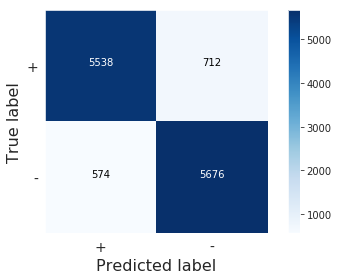

In [206]:
plot_confusion_matrix(c_matrix_rnn, ['+', '-'], title='', filename='fig5.eps')

### GRU

In [1]:
# This code was exploratory and is not crucial to the project. The model weights have not been included in the 
# submission to reduce the amount of space.

In [59]:
def build_model_gru(dropout, recurrent_dropout, optimizer, embedding=None, conv1d=False, bidirect=False, summary=True):
    
    if embedding is None:
        dim = 100
    else:
        dim = dim = embedding.get_weights()[0].shape[1]
    
    model = Sequential() 
    if embedding is None:
        model.add(Embedding(input_dim=12004, output_dim=dim, input_length=max_length))
    else:
        model.add(embedding)
    if conv1d:
        model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
    if bidirect:
        model.add(Bidirectional(GRU(dim, return_sequences=False, 
                                     dropout=dropout, recurrent_dropout=recurrent_dropout)))
    else:
        model.add(GRU(dim, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    if summary:
        model.summary()
    
    return model

In [60]:
def train_model_gru(params):
    
    dropout = params['dropout']
    recurrent_dropout = params['recurrent_dropout']
    optimizer = params['optimizer']
    embedding = params['embedding']
    conv1d = params['conv1d']
    bidirect = params['bidirect']
    model_no = params['model_no']
    batch_size = params['batch_size']

    model = build_model_gru(dropout, recurrent_dropout, optimizer, embedding, conv1d, bidirect)
    
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.gru.' + model_no + '.hdf5', 
                                   verbose=1, save_best_only=True)
    
    print('Training model', model_no)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, 
              batch_size=batch_size, callbacks=[checkpointer])
    print()

In [68]:
def best_model_gru(parameters):
    
    columns = list(parameters[0].keys())
    columns + ['val_acc']
    df = pd.DataFrame(columns=columns)

    best_params = None
    best_accuracy = 0
    
    for params in parameters:
        dropout = params['dropout']
        recurrent_dropout = params['recurrent_dropout']
        optimizer = params['optimizer']
        embedding = params['embedding']
        conv1d = params['conv1d']
        bidirect = params['bidirect']
        model_no = params['model_no']
        batch_size = params['batch_size']
        
        model = build_model_gru(dropout, recurrent_dropout, optimizer, embedding, conv1d, bidirect, summary=False)
        model.load_weights('saved_models/weights.gru.' + model_no + '.hdf5')
        print('Evaluating model', model_no)
        _, accuracy = model.evaluate(X_test, y_test)
        
        params['val_acc'] = accuracy
        df = df.append(params, ignore_index=True)
        
        if accuracy > best_accuracy:
            best_params = params
            best_accuracy = accuracy
        
    return best_params, best_accuracy, df

In [63]:
# Models to be evaluated

parameters = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, 
              model_9, model_10, model_11, model_12, model_13, model_14, model_15, model_16,
              model_17, model_18, model_19, model_20, model_21, model_22, model_23, model_24,
              model_25, model_26, model_27]

In [ ]:
# Train models
# Warning: Running this code will re-train the models and overwrite the saved models.

for params in parameters:
    train_model_gru(params)

In [70]:
# Evaluation summary

best_params, best_accuracy, df = best_model_gru(parameters)
df

Evaluating model 1
12500/12500 [==============================] - 31s 2ms/step
Evaluating model 2
12500/12500 [==============================] - 32s 3ms/step
Evaluating model 3
12500/12500 [==============================] - 29s 2ms/step
Evaluating model 4
12500/12500 [==============================] - 28s 2ms/step
Evaluating model 5
12500/12500 [==============================] - 28s 2ms/step
Evaluating model 6
12500/12500 [==============================] - 28s 2ms/step
Evaluating model 7
12500/12500 [==============================] - 30s 2ms/step
Evaluating model 8
12500/12500 [==============================] - 30s 2ms/step
Evaluating model 9
12500/12500 [==============================] - 18s 1ms/step
Evaluating model 10
12500/12500 [==============================] - 18s 1ms/step
Evaluating model 11
12500/12500 [==============================] - 18s 1ms/step
Evaluating model 12
12500/12500 [==============================] - 18s 1ms/step
Evaluating model 13
12500/12500 [================

,dropout,recurrent_dropout,optimizer,embedding,conv1d,bidirect,model_no,batch_size,val_acc
0,0.2,0.2,adam,None,False,False,1,32,0.87928
1,0.4,0.4,adam,None,False,False,2,32,0.88200
2,0.2,0.2,adam,None,False,False,3,64,0.86360
3,0.4,0.4,adam,None,False,False,4,64,0.84512
4,0.2,0.2,nadam,None,False,False,5,64,0.87920
5,0.4,0.4,nadam,None,False,False,6,64,0.88544
6,0.2,0.2,nadam,None,False,False,7,32,0.88704
7,0.4,0.4,nadam,None,False,False,8,32,0.89176
8,0.2,0.2,adam,None,True,False,9,32,0.88144
9,0.4,0.4,adam,None,True,False,10,32,0.86824


### Figure 6

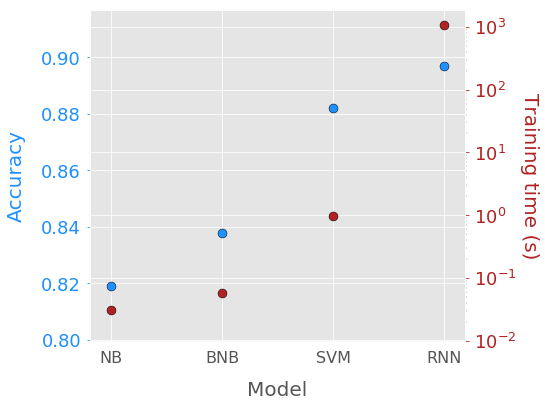

In [135]:
from mpltools import layout

plt.style.use('ggplot')
figsize = layout.figaspect(scale=1.2)

fig, ax1 = plt.subplots(figsize=figsize)
x = np.arange(0, 4, 1)
acc = [0.819, 0.838, 0.882, 0.897]
ax1.scatter(x, acc, c='dodgerblue', s=80, edgecolors='k')
ax1.set_xlabel('Model', fontsize=20, labelpad=15)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Accuracy', color='dodgerblue', fontsize=20, labelpad=15)
ax1.tick_params('y', colors='dodgerblue', labelsize=18)
ax1.tick_params('x', labelsize=18)
ax1.set_xticklabels(labels=['', 'NB', 'BNB', 'SVM', 'RNN'], fontdict={'fontsize':16})

ax2 = ax1.twinx()
time = [0.031, 0.058, 0.968, 1062] 
ax2.scatter(x, time, c='firebrick', s=80, edgecolors='k')
ax2.set_ylabel('Training time (s)', color='firebrick', fontsize=20, rotation=270, labelpad=22)
ax2.set_yscale('log')
ax2.tick_params('y', colors='firebrick', labelsize=18)

fig.tight_layout()
plt.savefig('fig6.eps', dpi=300, format='eps')
plt.show()